In [1]:
import numpy as np
from numpy.random import RandomState
import pandas as pd
from scipy.stats import cauchy, gamma, norm, dirichlet,  expon
from scipy.stats import beta as beta_dist
import time
import matplotlib.pyplot as plt

In [2]:
def prior(n, hyper):
    X_1 = beta_dist.rvs(hyper[0], hyper[1] + hyper[2], size=n)
    Temp = beta_dist.rvs(hyper[1], hyper[2], size=n)
    X_2 = Temp * (1 - X_1)
    R_1 = X_1 - X_2
    R_2 = 2 * (X_1 + X_2) - 1
    return np.column_stack((R_1, R_2))

def genParam(n, randomstate):
    r = RandomState(seed=randomstate)
    alpha = r.exponential(1, (n, 3))
    ksi = np.abs(r.standard_cauchy(2))
    beta = [r.dirichlet(alpha[0])]
    for i in range(1, n):
        betai = [r.dirichlet(alpha[i])]
        beta = np.concatenate((beta, betai), axis=0)
    mu = [[beta[0][0] - beta[0][1], 2 * (beta[0][0] + beta[0][1]) - 1]]
    for i in range(1, n):
        mui = [[beta[i][0] - beta[i][1], 2 * (beta[i][0] + beta[i][1]) - 1]]
        mu = np.concatenate((mu, mui), axis=0)
    sigma = r.wald(ksi[0], ksi[1], n)
    return alpha, ksi, beta, mu, sigma

def genX(n, T, mu, sigma):
    X = []
    for i in range(n):
        if mu[i][0] < T and mu[i][0] <= T + 2 and mu[i][1] < T and mu[i][1] <= T + 2:
            A = np.eye(T, T + 2) + mu[i][0] * np.eye(T, T + 2, 1) + mu[i][1] * np.eye(T, T + 2, 2)
            A = A @ A.T
            Xi = np.random.multivariate_normal(np.zeros(T), sigma[i] * A)
            X.append(Xi)
        else:
            print(f"Indices non valides pour mu[{i}]: {mu[i][0]}, {mu[i][1]}")
    return np.array(X)

def distautcor(Z, X):
    min_length = min(len(Z), len(X))
    Z = Z[:min_length]
    X = X[:min_length]
    
    p = len(Z)
    a2 = np.sum(Z[2:p] * Z[0:(p - 2)])
    b2 = np.sum(X[2:p] * X[0:(p - 2)])
    a1 = np.sum(Z[1:p] * Z[0:(p - 1)])
    b1 = np.sum(X[1:p] * X[0:(p - 1)])
    return np.sqrt((a2 - b2)**2 + (a1 - b1)**2)


In [3]:
def ABCbas(X, N, T, mu, sigma):
    distances = []
    for i in range(N):
        simulated_X = genX(1, T, [mu], [sigma])  
        distance = distautcor(X.flatten(), simulated_X.flatten())
        distances.append((distance, mu, sigma))
    min_distance_index = np.argmin([d[0] for d in distances])
    distance_values = np.array([d[0] for d in distances])
    return distances[min_distance_index][1], distances[min_distance_index][2]

def statdir(U):
    q = (U[:, 1] + 2 * U[:, 0] + 1) / 4
    q = np.where(q != 0, q, np.finfo(float).eps)  # Eviter la division par 0
    return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])

def ABChaut(Q1, Q2, L):
    Q = np.column_stack((Q1, Q2))
    hyper = expon.rvs(size=(L, 3))  
    dist = np.zeros(L)
    for i in range(L):
        U = prior(len(Q1), hyper[i]) 
        dist[i] = np.sum((statdir(U) - statdir(Q))**2)
    return hyper[np.argmin(dist)]

def ABCsigm(Dat, j, parh1, parh2, parsigm1, parsigm2, N, T):
    dist = np.zeros(N)
    w = np.arange(1, min(Dat.shape[0], 10))
    si = 1 / gamma.rvs(parsigm1, scale=parsigm2, size=N)
    for i in range(N):
        simulated_data = genX(1, T, np.array([[parh1[j], parh2[j]]]), np.array([si[i]]))
        if j >= Dat.shape[1]:
            raise IndexError(f"Index {j} is out of bounds for axis 1 with size {Dat.shape[1]}")
        valid_w = w[w < Dat.shape[0]] 
        if len(valid_w) == 0:
            raise ValueError("No valid indices in w for accessing Dat.")
        dist[i] = np.abs(np.var(simulated_data.flatten()[valid_w]) - np.var(Dat[valid_w, j]))
    return si[np.argmin(dist)]

def ABCsigmhaut(sigm, Q):
    dist = np.zeros(Q)
    pri = np.abs(cauchy.rvs(size=(Q, 2)))
    for i in range(Q):
        h = pri[i]
        y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))
        dist[i] = np.abs(np.sum(np.log(y)) - np.sum(np.log(sigm))) + np.abs(np.sum(y) - np.sum(sigm))
    return pri[np.argmin(dist)]

In [4]:
def GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T, randomstate=0):
    n = X.shape[1]  # Nombre de trajectoires dans les données d'entrée
    alpha, ksi, beta, mu, sigma = genParam(n, randomstate)
    
    start_time = time.time()

    eps_estimate = float('inf')  
    facteur_decroissance = 0.99 

    results = {
        "Paramètres_mu": [],
        "Paramètres_sigma": [],
        "Hyperparamètres": [],
        "Hypersigma": [],
        "Histeps": [],  
        "Eps_final": None  
    }
    
    for iteration in range(Npts):
        current_time = time.time()
        if current_time - start_time > temps_max:
            print(f"Temps maximum d'exécution de {temps_max} secondes atteint à la {iteration}ème itération.")
            break

        mu_updates = []
        sigma_updates = []
        dist_i = [] 

        for j in range(n):
            mu_best, sigma_best = ABCbas(X[:, j], N, T, mu[j], sigma[j])
            mu[j] = mu_best
            sigma[j] = sigma_best
            mu_updates.append(mu_best)
            sigma_updates.append(sigma_best)
            simu_j = genX(1, T, [mu[j]], [sigma[j]])  
            # Calculer la distance en utilisant la variance
            dist = np.abs(np.var(simu_j) - np.var(X[:, j]))
            dist_i.append(dist)
        
        # Mettre à jour eps_estimate avec la distance maximale de cette itération si elle est plus petite
        eps_iteration = max(dist_i)
        eps_estimate = min(eps_estimate, eps_iteration) * facteur_decroissance
        # Vérifier si l'estimation d'epsilon dépasse l'objectif après toutes les mises à jour
        if eps_estimate > objectifeps:
            print(f"L'objectif epsilon de {objectifeps} a été dépassé avec une estimation de {eps_estimate}. Arrêt du programme.")
            break  # Sortir de la boucle principale si l'objectif epsilon est dépassé

        results["Histeps"].append(eps_estimate)  
        results["Eps_final"] = eps_estimate
        results["Paramètres_mu"].append(mu_updates)
        results["Paramètres_sigma"].append(sigma_updates)
        
        # Mettre à jour les hyperparamètres à l'aide d'ABChaut 
        Q1, Q2 = mu[:, 0], mu[:, 1]
        hyper_best = ABChaut(Q1, Q2, M)
        
        # Mettre à jour le sigma à l'aide d'ABCsigm pour chaque trajectoire
        for j in range(n):
            sigma_j = ABCsigm(X, j, mu[:, 0], mu[:, 1], hyper_best[0], hyper_best[1], P, T)
            sigma[j] = sigma_j
        
        # Mettre à jour l'hypersigma à l'aide d'ABCsigmhaut
        hypersigma_best = ABCsigmhaut(sigma, P2)
        
        results["Hyperparamètres"].append(hyper_best)
        results["Hypersigma"].append(hypersigma_best)

    return results

In [5]:
N = 30  # Nombre de simulations pour les paramètres
M = 30  # Nombre de simulations pour l'hyperparamètre
P = 30  # Nombre de simulations pour sigma
P2 = 30  # Nombre de simulations pour hypersigma
Npts = 1000 # Nombre total d'itérations de l'algorithme global

n = 2  #Nombre de trajectoires dans les données d'entrée
T = 40 # Longueur des trajectoires dans les données d'entrée

objectifeps = 5 # Seuil de niveau d'erreur entre les données simulées et les données observées
temps_max = 20  # Temps d'éxecution maximum de l'algorithme global en secondes

alpha, ksi, beta, mu, sigma=genParam(n, randomstate=0)
X=genX(n, T, mu, sigma)

hyper_real= [1,2,3]
hypersigm_real= [1,1]

In [6]:
resultats = GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T)
resultats

C:\Users\sarah\AppData\Local\Temp\ipykernel_39276\2087604162.py:14: RuntimeWarning: divide by zero encountered in log
  return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])
C:\Users\sarah\AppData\Local\Temp\ipykernel_39276\2087604162.py:22: RuntimeWarning: invalid value encountered in subtract
  dist[i] = np.sum((statdir(U) - statdir(Q))**2)
C:\Users\sarah\AppData\Local\Temp\ipykernel_39276\924346944.py:30: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Xi = np.random.multivariate_normal(np.zeros(T), sigma[i] * A)


Temps maximum d'exécution de 20 secondes atteint à la 15ème itération.


{'Paramètres_mu': [[array([0.2102702 , 0.04554244]),
   array([-0.0766259 , -0.49571998]),
   array([-0.14756633, -0.37199812]),
   array([-0.18468036,  0.22977703]),
   array([-0.18263592,  0.99096723]),
   array([-0.26011435, -0.37116217]),
   array([ 0.10959831, -0.26611087]),
   array([0.75460589, 0.68634623]),
   array([-0.92257819,  0.99954389]),
   array([0.63635249, 0.97866264]),
   array([-0.9957607 ,  0.99165434]),
   array([0.6666296, 0.3518061]),
   array([-0.39170358,  0.16641593]),
   array([0.24305301, 0.5584517 ]),
   array([0.82027949, 0.6471776 ]),
   array([0.98932966, 0.99489403]),
   array([-0.64626291,  0.36717473]),
   array([-0.46766221,  0.99907094]),
   array([0.47477769, 0.24684741]),
   array([0.11646795, 0.99999633]),
   array([ 0.12159467, -0.75671341]),
   array([-0.31211714, -0.04084756]),
   array([ 0.20090981, -0.5851846 ]),
   array([-0.88296241,  0.76592483]),
   array([0.62750507, 0.50288082]),
   array([-0.87422479,  0.74844959]),
   array([0.86453

In [7]:
def evaluer_facteur_decroissance(X, N, M, P, P2, Npts, objectifeps, temps_max, T, facteurs):
    """
    Évalue l'impact de différents facteurs de décroissance sur l'algorithme GibbsABC.
    
    :param X: Les données d'entrée.
    :param facteurs: Une liste de facteurs de décroissance à tester.
    :return: Un dictionnaire contenant les résultats pour chaque facteur.
    """
    resultats_par_facteur = {}
    
    for facteur in facteurs:
        print(f"Évaluation du facteur de décroissance: {facteur}")
        resultats = GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T)
        facteur_decroissance=facteur
        # Évaluer les résultats ici (par exemple, en utilisant la distance finale eps_estimate)
        eps_final = resultats["Histeps"][-1] if resultats["Histeps"] else float('inf')
        print(f"Facteur de décroissance {facteur} a abouti à un eps_estimate final de {eps_final}")
        resultats_par_facteur[facteur] = eps_final
    
    return resultats_par_facteur

# Exemple d'utilisation
facteurs_test = [0.90, 0.92, 0.95, 0.97, 0.99]  # Différents facteurs de décroissance à tester
resultats_facteurs = evaluer_facteur_decroissance(X, N, M, P, P2, Npts, objectifeps, temps_max, T, facteurs_test)

# Trouver le facteur de décroissance optimal basé sur le critère choisi (ici, le plus petit eps_estimate final)
facteur_optimal = min(resultats_facteurs, key=resultats_facteurs.get)
print(f"Le facteur de décroissance optimal est {facteur_optimal} avec un eps_estimate de {resultats_facteurs[facteur_optimal]}")

Évaluation du facteur de décroissance: 0.9


C:\Users\sarah\AppData\Local\Temp\ipykernel_39276\2087604162.py:14: RuntimeWarning: divide by zero encountered in log
  return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])
C:\Users\sarah\AppData\Local\Temp\ipykernel_39276\2087604162.py:22: RuntimeWarning: invalid value encountered in subtract
  dist[i] = np.sum((statdir(U) - statdir(Q))**2)
C:\Users\sarah\AppData\Local\Temp\ipykernel_39276\924346944.py:30: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Xi = np.random.multivariate_normal(np.zeros(T), sigma[i] * A)
C:\Users\sarah\AppData\Local\Temp\ipykernel_39276\2087604162.py:44: RuntimeWarning: divide by zero encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))


Temps maximum d'exécution de 20 secondes atteint à la 15ème itération.
Facteur de décroissance 0.9 a abouti à un eps_estimate final de 3.5335691518294885
Évaluation du facteur de décroissance: 0.92


KeyboardInterrupt: 

In [8]:
def distance(resultats, hyper_real, hypersigm_real):

    hyper_real=np.array(hyper_real)
    hypersigm_real=np.array(hypersigm_real)

    hyper_estime = resultats["Hyperparamètres"]
    hypersigm_estime = resultats["Hypersigma"]

    dist_eucli_hyper= np.sqrt(np.sum((hyper_estime - hyper_real) ** 2, axis=1))
    dist_eucli_hypersigm= np.sqrt(np.sum((hypersigm_estime - hypersigm_real) ** 2, axis=1))
    
    # Calculer les distances euclidiennes
    distance_hyper = np.mean(dist_eucli_hyper)
    distance_hypersigm = np.mean(dist_eucli_hypersigm)

    return {
        'Distance Hyperparamètre': distance_hyper,
        'Distance Hypersigma': distance_hypersigm
    }

In [9]:
temps_max_values = [10, 30, 60, 120]
standard_error_hyper = []
standard_error_hypersigma = []
distance_hyper = []
distance_hypersigm = []
epsilon=[]

for temps_max in temps_max_values:
    resultats = GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max, T)
    hyper = resultats["Hyperparamètres"]
    hypersigma=resultats["Hypersigma"]
    std_hyper = np.std(hyper)
    std_hypersigma = np.std(hypersigma)
    standard_error_hyper.append(std_hyper)
    standard_error_hypersigma.append(std_hypersigma)

    epsilon.append(resultats["Eps_final"]) 

    dist = distance(resultats, hyper_real, hypersigm_real)
    dist_hyper=dist['Distance Hyperparamètre']
    dist_hypersigm=dist['Distance Hypersigma']
    distance_hyper.append(dist_hyper)
    distance_hypersigm.append(dist_hypersigm)


C:\Users\sarah\AppData\Local\Temp\ipykernel_39276\2087604162.py:14: RuntimeWarning: divide by zero encountered in log
  return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])
C:\Users\sarah\AppData\Local\Temp\ipykernel_39276\2087604162.py:22: RuntimeWarning: invalid value encountered in subtract
  dist[i] = np.sum((statdir(U) - statdir(Q))**2)
C:\Users\sarah\AppData\Local\Temp\ipykernel_39276\924346944.py:30: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Xi = np.random.multivariate_normal(np.zeros(T), sigma[i] * A)


Temps maximum d'exécution de 10 secondes atteint à la 8ème itération.


C:\Users\sarah\AppData\Local\Temp\ipykernel_39276\2087604162.py:44: RuntimeWarning: divide by zero encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))
C:\Users\sarah\AppData\Local\Temp\ipykernel_39276\2087604162.py:44: RuntimeWarning: overflow encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=len(sigm))


Temps maximum d'exécution de 30 secondes atteint à la 23ème itération.
Temps maximum d'exécution de 60 secondes atteint à la 45ème itération.
Temps maximum d'exécution de 120 secondes atteint à la 90ème itération.


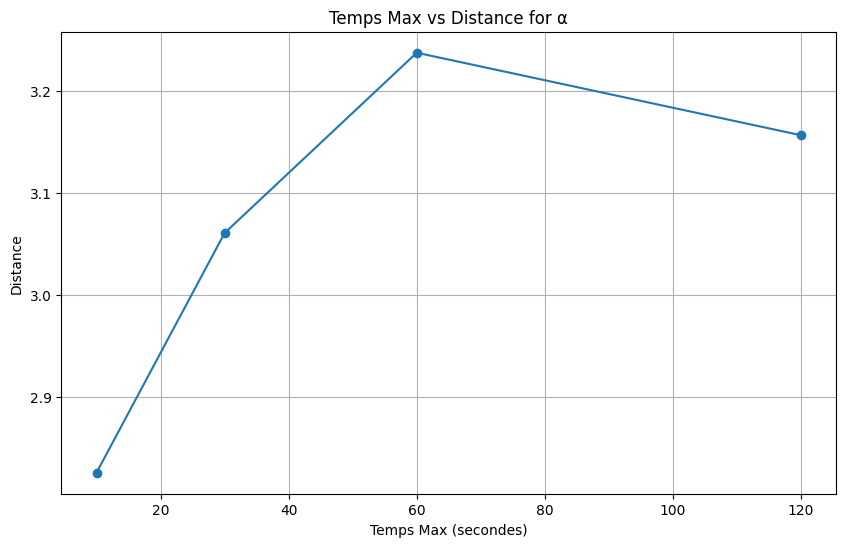

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, distance_hyper,  marker='o', linestyle='-')
plt.title('Temps Max vs Distance for α')
plt.xlabel('Temps Max (secondes)')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

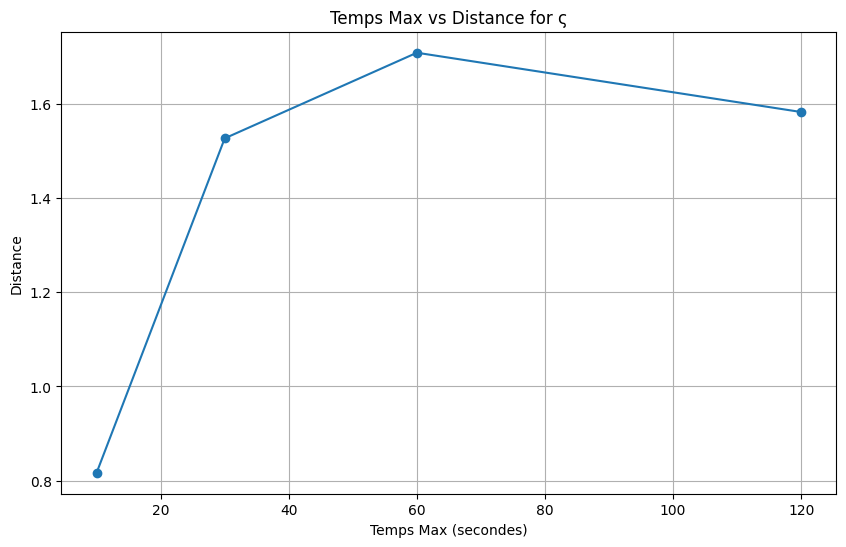

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, distance_hypersigm, marker='o', linestyle='-')
plt.title('Temps Max vs Distance for ς')
plt.xlabel('Temps Max (secondes)')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

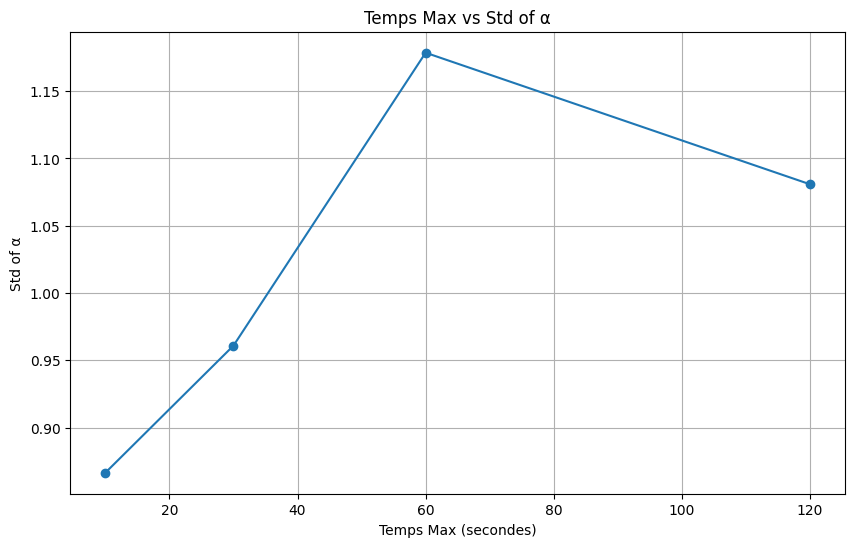

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, standard_error_hyper, marker='o', linestyle='-')
plt.title('Temps Max vs Std of α')
plt.ylabel('Std of α')
plt.xlabel('Temps Max (secondes)')
plt.grid(True)
plt.show()

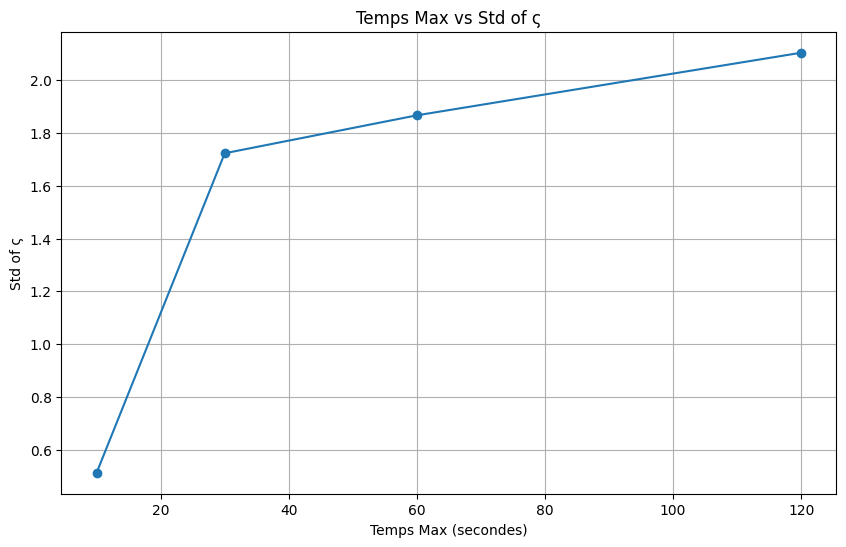

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, standard_error_hypersigma, marker='o', linestyle='-')
plt.title('Temps Max vs Std of ς')
plt.ylabel('Std of ς')
plt.xlabel('Temps Max (secondes)')
plt.grid(True)
plt.show()

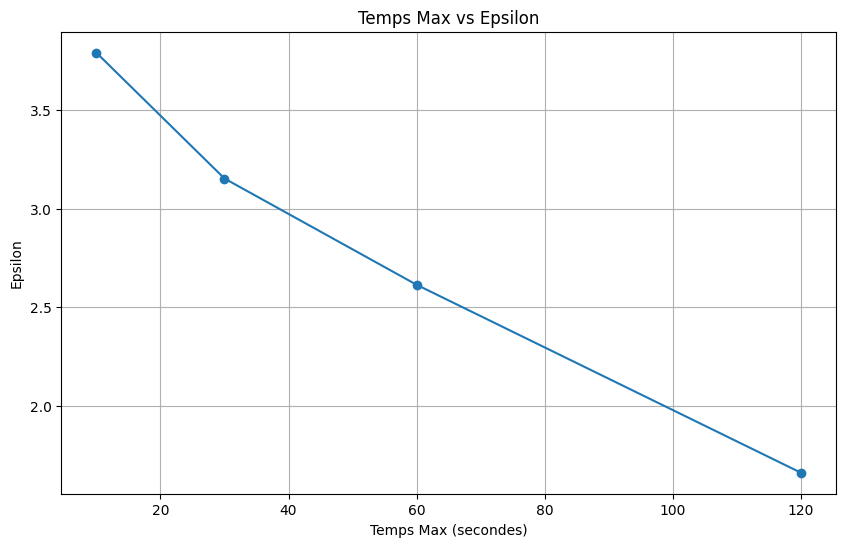

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, epsilon,  marker='o', linestyle='-')
plt.title('Temps Max vs Epsilon')
plt.xlabel('Temps Max (secondes)')
plt.ylabel('Epsilon')
plt.grid(True)
plt.show()